<a href="https://colab.research.google.com/github/Cami101/Houston-housing-predictor/blob/main/Houston_house_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from PIL import Image, ImageOps
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import defaultdict

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.2 MB/s eta 0:00:00


In [ ]:
from torchmetrics import MeanSquaredError

In [ ]:
# additional modules / libraries to import
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torchvision.models as models
from torch import Tensor

In [ ]:
torch.__version__

'2.1.0+cu118'

In [ ]:
device = "cpu"
if (torch.cuda.is_available()):
  device = "cuda"
print("device: " + device)

device: cuda


In [ ]:
# note that this command will trigger a request from google to allow colab
# to access your files: you will need to accept the terms in order to access
# the files this way
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# if you followed the instructions above exactly, your zipped data file should
# be located at the file path below; if your files are in a different directory
# on your Google Drive, you will need to change the path below accordingly
ZIPPATH = '/content/drive/My Drive/comp341/comp341-hw6.zip'

Mounted at /content/drive


In [ ]:
!cp "{ZIPPATH}" .
!unzip -q "comp341-hw6.zip"
!rm "comp341-hw6.zip"

In [ ]:
# torch converts the 0-255 RGB values to 0-1 tensors, but it can
# also be beneficial to also standardize the values (or, as we
# see here, subtract the mean RGB values from the images)

# these transformations below help facilitate this
# inv_normalize is provided mainly for visualization sake, so that
# we can flip the standardization process to see the image in its
# original colors

house_mean = [0.5230, 0.5416, 0.4989]
# house_sd = [0.2271, 0.2162, 0.2640]
# only subtracting mean and not also dividing by standard deviation
# can actually sometimes work better, which is what we are doing here
house_sd = [1, 1, 1]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(house_mean, house_sd)
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(house_mean, house_sd)],
   std= [1/s for s in house_sd]
)


In [ ]:
# convenient function for displaying images
# by default, will reverse the standardization calculation so that we can
# see the images in a "normal" color scheme
def display_data(d, inv_norm=True):
  if isinstance(d['houseid'], list): # we can handle a list of houses
    batch_size = len(d['houseid'])
    for i in range(batch_size):
      if 'price' in d:
        print('price:', "${:,.0f}".format(d['price'][i]))

      if inv_norm:
       display(transforms.ToPILImage()(inv_normalize(d['image'][i])))
      else:
        display(transforms.ToPILImage()(d['image'][i]))
  else: # only an individual house to be displayed
    if 'price' in d:
      print('price:', "${:,.0f}".format(d['price']))

    if inv_norm:
      display(transforms.ToPILImage()(inv_normalize(d['image'])))
    else:
      display(transforms.ToPILImage()(d['image']))

In [ ]:
##selected 72 features for training and testing, after many experiments with HouseImagesDataset, I decided to drop zipcodes that < 25 houses have, and drop one property type
## "property_type_Multi-Family (2-4 Unit)"

final_feature_names = ['beds', 'baths', 'sqft', 'lot_size', 'year_built', 'property_type_Single Family Residential', 'property_type_Townhouse',
                      'zipcode_77004', 'zipcode_77005', 'zipcode_77006', 'zipcode_77007', 'zipcode_77008', 'zipcode_77009',
                      'zipcode_77014', 'zipcode_77015', 'zipcode_77016', 'zipcode_77018', 'zipcode_77019', 'zipcode_77020', 'zipcode_77021',
                      'zipcode_77022', 'zipcode_77023', 'zipcode_77024', 'zipcode_77025', 'zipcode_77026', 'zipcode_77027', 'zipcode_77030',
                      'zipcode_77034', 'zipcode_77035', 'zipcode_77041', 'zipcode_77042', 'zipcode_77043', 'zipcode_77044', 'zipcode_77045',
                      'zipcode_77047', 'zipcode_77049', 'zipcode_77051', 'zipcode_77053', 'zipcode_77054', 'zipcode_77055', 'zipcode_77056',
                      'zipcode_77057', 'zipcode_77062', 'zipcode_77063', 'zipcode_77068', 'zipcode_77069', 'zipcode_77070', 'zipcode_77072',
                      'zipcode_77073', 'zipcode_77076', 'zipcode_77077', 'zipcode_77079', 'zipcode_77080', 'zipcode_77082', 'zipcode_77083',
                      'zipcode_77084', 'zipcode_77088', 'zipcode_77089', 'zipcode_77090', 'zipcode_77091', 'zipcode_77092', 'zipcode_77095',
                      'zipcode_77096', 'zipcode_77098', 'zipcode_77339', 'zipcode_77345', 'zipcode_77346', 'zipcode_77379', 'zipcode_77433',
                      'zipcode_77449', 'zipcode_77494']

In [ ]:
class HouseImagesDataset(Dataset): # [4 pts]
    def __init__(self, annot_file, image_dir, train=True):
        # the annotation file is tidy, aka each row is a unique observation in the dataset,
        # but it is not yet clean, which you will address in the TODO below
        df = pd.read_csv(annot_file)
        # print(df.loc[:,'list_price'].idxmin())

        # Missing values
        continuous = ["beds", "baths", "sqft", "lot_size", 'year_built']
        imputer = KNNImputer(n_neighbors=3)
        df[continuous] = pd.DataFrame(imputer.fit_transform(df[continuous]))


        # TODO: cleaning / preprocessing of features in df

        # One hot encoding
        df = pd.get_dummies(df, columns=['property_type'], drop_first=True)
        df = pd.get_dummies(df, columns=['zipcode'], drop_first=True)

        cs = MinMaxScaler()
        df[continuous] = cs.fit_transform(df[continuous])


        # TODO: fill in this feature_cols list with the column names of
        # features you would like to use to predict list price (many of the columns
        # will likely be transformed from the original data in annot_file)

        self.feature_cols = final_feature_names
        self.house_annot = df
        self.image_dir = image_dir
        self.train=train

    def __len__(self):
        # TODO: fill in this method (replacing pass) to return the length of the dataset
        return len(self.house_annot)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # we have provided code that will load and transform the indexed ("ith") image
        # as well as features specified earlier in self.feature_cols within the processed
        # pandas DataFrame
        img = Image.open(os.path.join(self.image_dir, str(self.house_annot.loc[idx, 'houseid']) + '.jpg'))
        img = transform(img)
        img = img

        features = self.house_annot.loc[idx, self.feature_cols]
        features = features.tolist()
        features = torch.FloatTensor(features)

        # depending on whether the Dataset is in training mode, we will have the price data or not
        if self.train:
            item = {'image': img,
                    'houseid': self.house_annot.loc[idx, 'houseid'],
                    'features': features,
                    'price': torch.tensor(self.house_annot.loc[idx, 'list_price'], dtype=torch.float)}
        else:
            item = {'image': img,
                    'houseid': self.house_annot.loc[idx, 'houseid'],
                    'features': features}

        return item

    def GetX(self):
        return self.house_annot[final_feature_names]

    def GetY(self):
        return self.house_annot["list_price"]

In [ ]:
# TODO: initialize the house dataset using the training data you were provided and check the length of the dataset [1 pt]
house_dataset = HouseImagesDataset(annot_file= "home_data_train.csv", image_dir="house_imgs")
dataset_length = len(house_dataset)

# length is 4000
print(f"Length of the dataset: {dataset_length}")

Length of the dataset: 4000


In [ ]:
# TODO: use the convenient torch.utils.data.random_split function to split your loaded dataset into training and
# validation portions, using 75% of the data for training and 25% of the data for validation [1 pt]
train_size = int(0.75 * dataset_length)
val_size = dataset_length - train_size

train_dataset, val_dataset = torch.utils.data.random_split(house_dataset, [train_size, val_size])

In [ ]:
class CustomAugmentation:
    def __init__(self, seed):
        self.seed = seed

    def __call__(self, img):

        # Random Rotation
        transform_rotation = transforms.RandomRotation(degrees=(-25, 30), expand=False, center=None)
        img = transform_rotation(img)

        # Random Brightness
        transform_brightness = transforms.ColorJitter(brightness= 0.45, contrast=0, saturation=0, hue=0)
        img = transform_brightness(img)

        # Random Contrast
        transform_contrast = transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0)
        img = transform_contrast(img)

        # Ensure the tensor is in the range [0, 1]
        img = torch.clamp(img, 0, 1)

        return img

In [ ]:
class HybridHouseNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.aug = CustomAugmentation(6)

    self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.batch_norm1 = nn.BatchNorm2d(32)
    self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2))
    self.dropout1 = nn.Dropout(0.2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), padding=2)
    self.relu2 = nn.ReLU()
    self.batch_norm2 = nn.BatchNorm2d(64)
    self.max_pool2 = nn.MaxPool2d(kernel_size=(2, 2))
    self.dropout2 = nn.Dropout(0.2)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
    self.relu3 = nn.ReLU()
    self.batch_norm3 = nn.BatchNorm2d(128)
    self.max_pool3 = nn.MaxPool2d(kernel_size=(2, 2))
    self.dropout3 = nn.Dropout(0.3)

    self.conv4 = nn.Conv2d(128, 256, kernel_size=(5, 5), padding=2)
    self.relu4 = nn.ReLU()
    self.batch_norm4 = nn.BatchNorm2d(256)
    self.max_pool4 = nn.MaxPool2d(kernel_size=(2, 2))
    self.dropout4 = nn.Dropout(0.3)

    self.conv5 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1)
    self.relu5 = nn.ReLU()
    self.batch_norm5 = nn.BatchNorm2d(512)
    self.max_pool5 = nn.MaxPool2d(kernel_size=(2, 2))
    self.dropout5 = nn.Dropout(0.3)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(512 * (128 // (2**5)) * (128 // (2**5)), 2048)
    self.relu_fc1 = nn.ReLU()
    self.dropout_fc1 = nn.Dropout(0.5)

    self.fc2 = nn.Linear(2048, 256)
    self.relu_fc2 = nn.ReLU()



    # MLP for processing tabular features
    self.mlp = nn.Sequential(
            nn.Linear(71, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

    # Fully connected layers for combining image and tabular features
    self.fc_combined = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

  def forward(self, x_img, x_feats):
    x_img = self.aug(x_img)
    x_img = self.max_pool1(self.batch_norm1(self.relu1(self.conv1(x_img))))
    x_img = self.dropout1(x_img)

    x_img = self.max_pool2(self.batch_norm2(self.relu2(self.conv2(x_img))))
    x_img = self.dropout2(x_img)

    x_img = self.max_pool3(self.batch_norm3(self.relu3(self.conv3(x_img))))
    x_img = self.dropout3(x_img)

    x_img = self.max_pool4(self.batch_norm4(self.relu4(self.conv4(x_img))))
    x_img = self.dropout4(x_img)

    x_img = self.max_pool5(self.batch_norm5(self.relu5(self.conv5(x_img))))
    x_img = self.dropout5(x_img)

    x_img = self.flatten(x_img)

    x_img = self.fc1(x_img)
    x_img = self.relu_fc1(x_img)
    x_img = self.dropout_fc1(x_img)

    x_img = self.fc2(x_img)
    x_img = self.relu_fc2(x_img)

    # Tabular feature processing
    x_feats = self.mlp(x_feats)

    # Concatenate image and tabular features
    x = torch.cat([x_feats, x_img], dim=1)

    x = self.fc_combined(x)
    return x


In [ ]:
## extra model
class Res34HybridHouseNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.aug = CustomAugmentation(6)
    alexnet = models.alexnet(pretrained=True)
    alexnet.features[0] = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
    alexnet.features = nn.Sequential(*list(alexnet.features.children())[:-1])
    self.cnn = nn.Sequential(*list(alexnet.children())[:-1])

    # MLP for processing tabular features
    self.mlp = nn.Sequential(
            nn.Linear(71, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

    # Fully connected layers for combining image and tabular features
    self.fc_combined = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

  def forward(self, x_img, x_feats):
    x_img = self.aug(x_img)
    x_img = self.cnn(x_img)
    x_img = F.adaptive_avg_pool2d(x_img, (1, 1))
    x_img = x_img.view(x_img.size(0), -1)

    x_feats = self.mlp(x_feats)

    # Concatenate image and tabular features
    x = torch.cat([x_feats, x_img], dim=1)


    x = self.fc_combined(x)
    return x

Before training our model, we want to also set up some additional models to what the differences might be if we use *only* images or *only* the tabular features for our predictions. Of course, if we set the models up differently with different hyperparameters, we really cannot have a truly equivalent comparison, but we will try to keep as many of the model blocks the same as possible.

In [ ]:
class HouseImageOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.aug = CustomAugmentation(6)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), padding=2)
        self.relu2 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.max_pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.relu3 = nn.ReLU()
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.max_pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=(5, 5), padding=2)
        self.relu4 = nn.ReLU()
        self.batch_norm4 = nn.BatchNorm2d(256)
        self.max_pool4 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout4 = nn.Dropout(0.3)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1)
        self.relu5 = nn.ReLU()
        self.batch_norm5 = nn.BatchNorm2d(512)
        self.max_pool5 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout5 = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * (128 // (2**5)) * (128 // (2**5)), 2048)
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(2048, 256)
        self.relu_fc2 = nn.ReLU()

        self.fc_combined = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

    def forward(self, x_img):
        x_img = self.aug(x_img)
        x_img = self.max_pool1(self.batch_norm1(self.relu1(self.conv1(x_img))))
        x_img = self.dropout1(x_img)

        x_img = self.max_pool2(self.batch_norm2(self.relu2(self.conv2(x_img))))
        x_img = self.dropout2(x_img)

        x_img = self.max_pool3(self.batch_norm3(self.relu3(self.conv3(x_img))))
        x_img = self.dropout3(x_img)

        x_img = self.max_pool4(self.batch_norm4(self.relu4(self.conv4(x_img))))
        x_img = self.dropout4(x_img)

        x_img = self.max_pool5(self.batch_norm5(self.relu5(self.conv5(x_img))))
        x_img = self.dropout5(x_img)

        x_img = self.flatten(x_img)

        x_img = self.fc1(x_img)
        x_img = self.relu_fc1(x_img)
        x_img = self.dropout_fc1(x_img)

        x_img = self.fc2(x_img)
        x_img = self.relu_fc2(x_img)

        x_img = self.fc_combined(x_img)

        return x_img


In [ ]:
class HouseFeatsOnly(nn.Module):
  def __init__(self):
    super().__init__()

    # MLP for processing tabular features
    self.mlp = nn.Sequential(
            nn.Linear(71, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

    # Fully connected layers for combining image and tabular features
    self.fc_combined = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

  def forward(self, x_feats):
    # Tabular feature processing
    x_feats = self.mlp(x_feats)

    x = self.fc_combined(x_feats)
    return x


In [ ]:
loss_fn = MeanSquaredError(squared=False).to(device)

In [ ]:
# class L1LossFlat(nn.SmoothL1Loss):
#     def forward(self, input: Tensor, target: Tensor) -> Tensor:
#         return super().forward(input.view(-1), target.view(-1))
# loss_fn = L1LossFlat()

In [ ]:
def train(model, train_loader, opt, epoch, mode="both", verbose=False):
  # mode can be "both", "image", or "features", depending on if we are using
  # our HybridHouseNN, HouseImageOnly, or HouseFeatsOnly model
  # we will assume that the model passed to this function matches the mode,
  # and mode will affect whether the model uses image, features, or a combination
  # as input to get the predictions in the forward pass

  if verbose:
    print("starting epoch", epoch)
  train_loss = 0
  for i, batch in enumerate(train_loader):
    image, features, price = batch['image'].to(device), \
                             batch['features'].to(device), \
                             batch['price'].to(device)

    model.train(True)

    # TODO: fill in the code for each of the steps in the
    # training loop, remembering that we want to account for
    # different modes in the forward pass step [2 pts]

    if mode == "both":
      predictions = model(image, features)
    elif mode == "res34":
        predictions = model(image, features)
    elif mode == "image":
      predictions = model(image)
    else:
      predictions = model(features)

    predictions = torch.squeeze(predictions, dim=1)
    loss = loss_fn(predictions, price)

    loss.backward()
    opt.step()
    train_loss += loss.item()
    opt.zero_grad()


    model.train(False)
    if verbose and ((i % 20) == 0):
      print('training [epoch {}: {}/{} ({:.0f}%)] loss: {:.6f}'.format(
          epoch, i * len(image), len(train_loader.dataset),
          100. * i / len(train_loader), loss.item()))

  avg_tl = train_loss / (i+1)
  print('epoch {} avg training loss: {:.6f}'.format(epoch, avg_tl))
  return avg_tl

In [ ]:
def valid(model, valid_loader, mode="both"):
  # as in train, mode can be "both", "image", or "features", depending on if we are using
  # our HybridHouseNN, HouseImageOnly, or HouseFeatsOnly model
  # we will assume that the model passed to this function matches the mode,
  # and mode will affect whether the model uses image, features, or a combination
  # as input to get the predictions in the forward pass
  valid_loss = 0
  correct = 0
  with torch.no_grad():
    for i, batch in enumerate(valid_loader):
      image, features, price = batch['image'].to(device), \
                               batch['features'].to(device), \
                               batch['price'].to(device)

      # TODO: fill in code to calculate pred (the prediction), paying attention to
      # different usage of the model depending on the inputted mode variable [1 pt]
      if mode == "both":
        predictions = model(image, features)
      elif mode == "res34":
        predictions = model(image, features)
      elif mode == "image":
        predictions = model(image)
      else:
        predictions = model(features)

      predictions = torch.squeeze(predictions, dim=1)
      # get loss
      valid_loss += loss_fn(predictions, price).item()


  # get the loss for the epoch
  avg_vl = valid_loss / (i+1)
  print('avg validation loss: {:.6f}'.format(avg_vl))

  return avg_vl

In [ ]:
# TODO: initialize your training and validation DataLoaders, using a batch_size of 64
# and remembering to randomize the order the data points are presented to the model [1 pt]
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# we will use these simple dictionaries to keep track of the loss for our 3 different models
# note that depending on how complex your 3 models are, training may take some time, on the scale
# of 15-30 minutes
# with verbose on below, you should be seeing continual progress during training: if not, then
# double check that you are using GPUs and the image files locally within your colab instance
epoch_list = defaultdict(list)
train_loss = defaultdict(list)
valid_loss = defaultdict(list)
# 'both': HybridHouseNN(), 'image': HouseImageOnly(), 'res34': Res34HybridHouseNN(), 'features': HouseFeatsOnly(),
epochs = 30
torch.manual_seed(67)
modes = {'both': HybridHouseNN(), 'image': HouseImageOnly(), 'features': HouseFeatsOnly()}
for m in modes:
  model = modes[m].to(device)
  # TODO: initialize the optimizer (and associated hyperparameters like learning rate) of your choice [1 pt]
  opt = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay = 1e-3)

  print("Current mode:", m)
  for e in range(1, epochs+1):
    epoch_list[m].append(e)
    train_loss[m].append(train(model, train_loader, opt, e, m, verbose=False))
    val_loss = valid(model, valid_loader, m)
    valid_loss[m].append(val_loss)


Current mode: both
epoch 1 avg training loss: 627592.414894
avg validation loss: 849921.982422
epoch 2 avg training loss: 502490.294880
avg validation loss: 719893.359375
epoch 3 avg training loss: 424966.639628
avg validation loss: 649769.236328
epoch 4 avg training loss: 371164.840758
avg validation loss: 572077.544922
epoch 5 avg training loss: 337201.302527
avg validation loss: 507045.513672
epoch 6 avg training loss: 327951.781416
avg validation loss: 493954.918945
epoch 7 avg training loss: 309007.938497
avg validation loss: 517741.109375
epoch 8 avg training loss: 312954.270944
avg validation loss: 465225.618164
epoch 9 avg training loss: 305665.766622
avg validation loss: 455071.506836
epoch 10 avg training loss: 284737.535406
avg validation loss: 446059.559570
epoch 11 avg training loss: 305752.380485
avg validation loss: 433536.013672
epoch 12 avg training loss: 296742.511303
avg validation loss: 465278.391602
epoch 13 avg training loss: 280687.475066
avg validation loss: 465

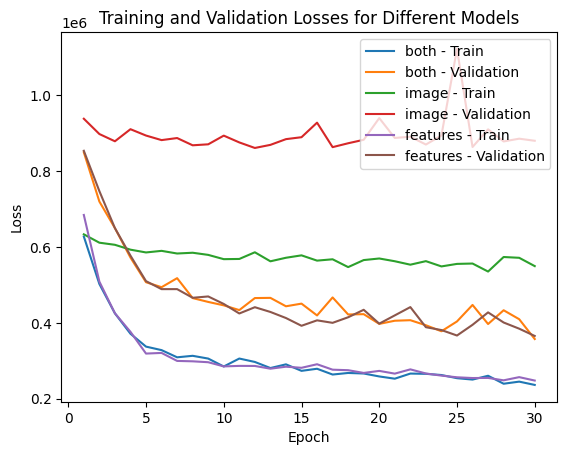

In [ ]:
# TODO: on a single plot, plot the training and validation losses for your 3 different models [2 pts]
for m in modes:
    plt.plot(epoch_list[m], train_loss[m], label=f'{m} - Train')
    plt.plot(epoch_list[m], valid_loss[m], label=f'{m} - Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Models')
plt.legend()
plt.show()

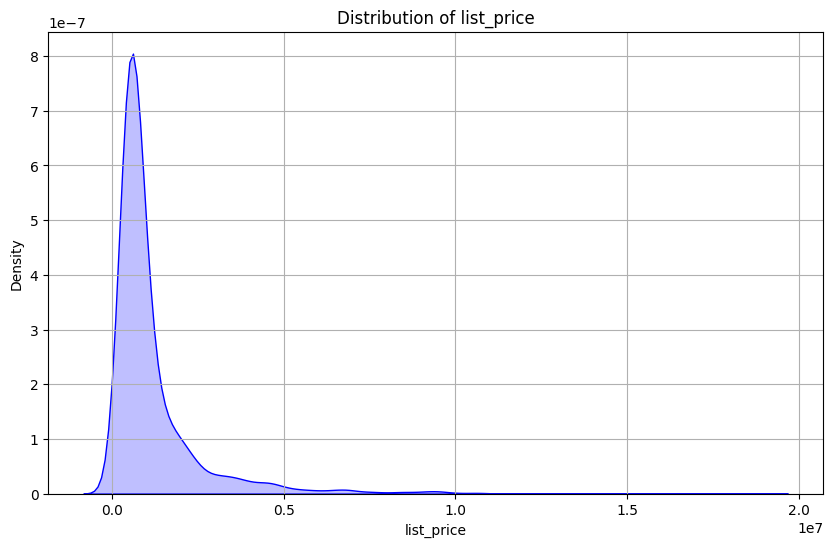

In [ ]:
batch_size = 64
house_testset = HouseImagesDataset(annot_file= "home_data_test.csv", image_dir="house_imgs",  train=False)
test_loader = DataLoader(house_testset, batch_size=batch_size, shuffle=False,)
lst = []
with torch.no_grad():
  for i, batch in enumerate(test_loader):
    image, features = batch['image'].to(device), \
                              batch['features'].to(device)
    pred = model(features)
    pred = torch.squeeze(pred, dim=1)
    lst.append(pred.cpu().numpy())

y_pred_kagg = np.concatenate(lst)

plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred_kagg, color='blue', fill=True)
plt.title('Distribution of list_price')
plt.xlabel('list_price')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [ ]:
df_test = pd.read_csv("home_data_test.csv")
results = pd.Series(y_pred_kagg.flatten(), name="price")
print("Min Price:", results.min())
print("Max Price:", results.max())
max_value = 6000000
min = 10000
# Count the number of values greater than max_value
count_above_max = (results > max_value).sum()

# Print the result
print(f"Number of values above {max_value}: {count_above_max}")
results = pd.concat([df_test['houseid'], results], axis=1)
results.to_csv('my_submission.csv', index=False)

Min Price: 31198.055
Max Price: 18815484.0
Number of values above 6000000: 61


In [ ]:
##Second method: decision tree regressor

df = pd.read_csv("home_data_train.csv")
X = df.drop('list_price', axis=1)

y = df.loc[:,'list_price']
print(y.max())
print(y.min())

selected_features = ['property_type', 'beds', 'baths', 'sqft', 'lot_size', 'year_built', 'latitude', 'longitude']
X_selected = X[selected_features]
X_encoded = pd.get_dummies(X_selected, columns=['property_type'], drop_first=True)

imputer = KNNImputer(n_neighbors=3)
X_imputed = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

17850000
41000


Min Price: 45000.0
Max Price: 17850000.0
Number of values above 6000000: 9


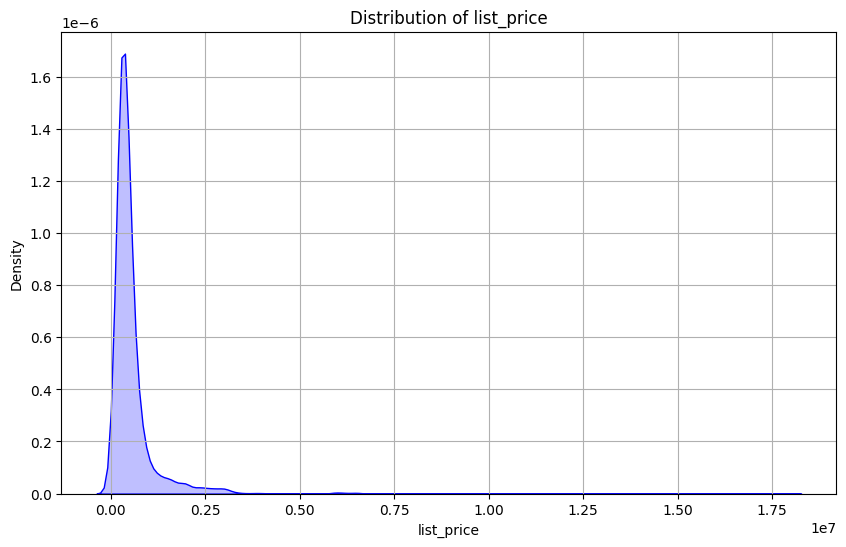

In [ ]:
df_test = pd.read_csv("home_data_test.csv")

X_test = df_test[selected_features]
X_test = pd.get_dummies(X_test, columns=['property_type'], drop_first=True)

imputer = KNNImputer(n_neighbors=3)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)
X_test.rename(columns={'property_type_Multi-Family (5+ Unit)': 'property_type_Multi-Family (2-4 Unit)'}, inplace=True)

from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(max_depth=20)
dt_regressor.fit(X_imputed, y)
y_pred_kagg = dt_regressor.predict(X_test)
results = pd.Series(y_pred_kagg.flatten(), name="price")
print("Min Price:", results.min())
print("Max Price:", results.max())
max_value = 6000000
count_above_max = (results > max_value).sum()
print(f"Number of values above {max_value}: {count_above_max}")
results = pd.concat([df_test['houseid'], results], axis=1)
results.to_csv('my_submission.csv', index=False)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred_kagg, color='blue', fill=True)
plt.title('Distribution of list_price')
plt.xlabel('list_price')
plt.ylabel('Density')
plt.grid(True)
plt.show()